<a href="https://colab.research.google.com/github/Yadukrishnan1/Fraud-Detection/blob/main/churn_robinhhod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is Churn?

Churn rate is calculated by dividing the number of customer cancellations within a time period by the number of active customers at the start of that period. Very valuable insights can be gathered from this simple analysis — for example, the overall churn rate can provide a benchmark against which to measure the impact of a model. And knowing how churn rate varies by time of the week or month, product line, or customer cohort can help inform simple customer segments for targeting as well.

However, churn is often needed at more granular customer level. Customers vary in their behaviors and preferences, which in turn influence their satisfaction or desire to cancel service. Therefore, a cohort-based churn rate may not be enough for precise targeting or real-time risk prediction. This is where churn modeling is usually most useful.

The output of a predictive churn model is a measure of the immediate or future risk of a customer cancellation. This is what the term "churn modeling" most often refers to, and is the definition we will adhere to in this post.

In [470]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Scikit-learn for ML prediction and modelling

from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.metrics import mean_squared_error, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
from mpl_toolkits import mplot3d
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold, RandomizedSearchCV

from xgboost.sklearn import XGBRegressor, XGBClassifier
import xgboost as xgb

from os import path

%matplotlib inline

In [471]:
import imblearn

In [472]:
PATH="/content/drive/MyDrive/Colab Notebooks/Robinhood/"

In [473]:
feat_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Robinhood/features_data.csv")
eq_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Robinhood/equity_value_data.csv")

In [474]:
print(eq_df.shape, '\n')
eq_df.head()

(1119158, 3) 



,timestamp,close_equity,user_id
0,2016-11-16T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
1,2016-11-17T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
2,2016-11-18T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
3,2016-11-21T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
4,2016-11-22T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03


In [475]:
eq_df.isna().sum()

timestamp       0
close_equity    0
user_id         0
dtype: int64

In [476]:
eq_df.timestamp=pd.to_datetime(eq_df.timestamp, errors='coerce')
eq_df.nunique()

timestamp          255
close_equity    531483
user_id           5584
dtype: int64

In [477]:
eq_df['gap_days'] = eq_df.timestamp.diff()
eq_df.head(10)

,timestamp,close_equity,user_id,gap_days
0,2016-11-16 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,NaT
1,2016-11-17 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days
2,2016-11-18 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days
3,2016-11-21 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,3 days
4,2016-11-22 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days
5,2016-11-23 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days
6,2016-11-25 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2 days
7,2016-11-28 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,3 days
8,2016-11-29 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days
9,2016-11-30 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days


In [478]:
# The number of users who have churned

churned_user_count=eq_df[eq_df['gap_days']>=pd.Timedelta("28 days")]['user_id'].nunique()
churned_user_ids=eq_df[eq_df['gap_days']>=pd.Timedelta("28 days")]['user_id'].unique()
print(len(churned_user_ids))

# Total users
total_users=eq_df['user_id'].nunique()
total_user_ids=eq_df['user_id'].unique()
print(len(total_user_ids))


287
5584


In [479]:
frac=np.round(100.0*(churned_user_count/total_users), decimals=2)
print('Fraction of churned users is {0}%'.format(frac))

Fraction of churned users is 5.14%


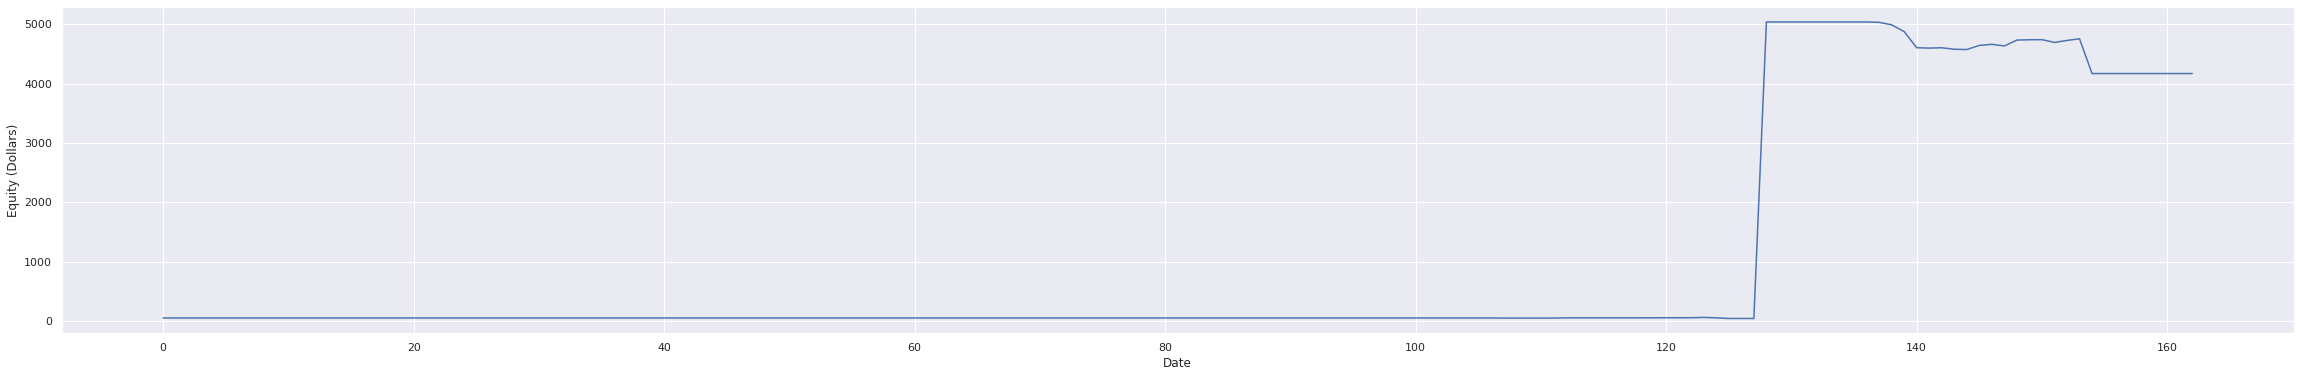

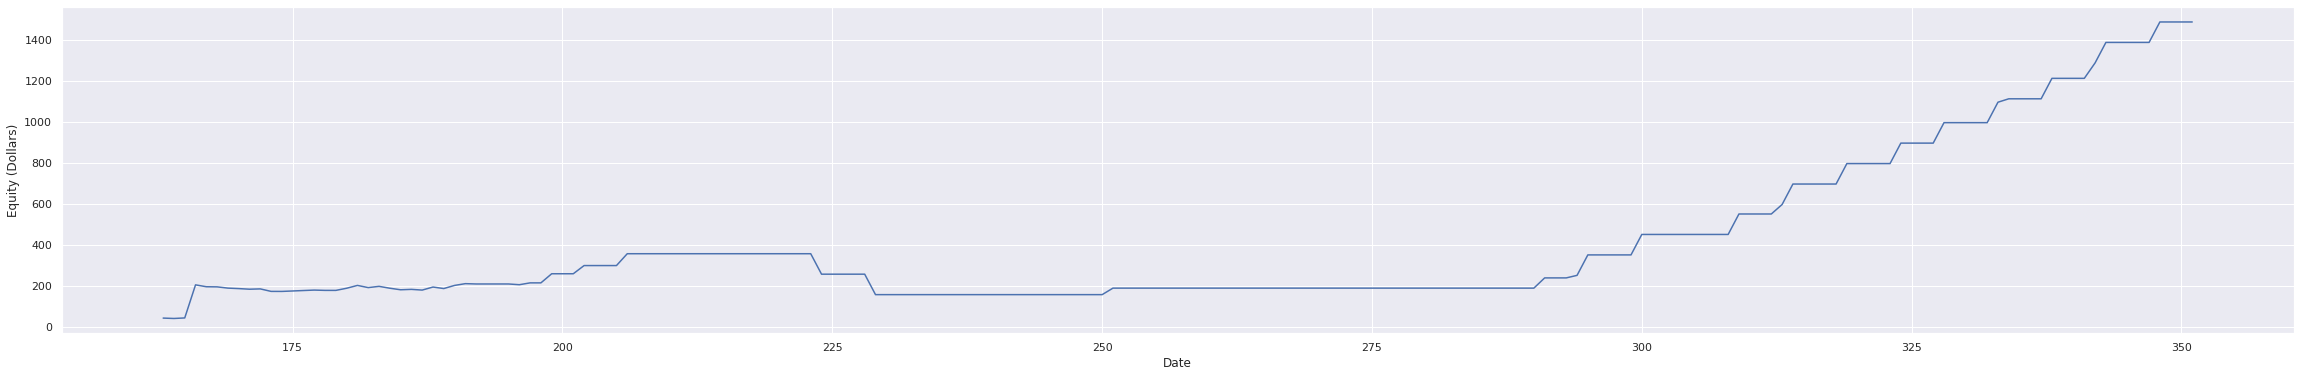

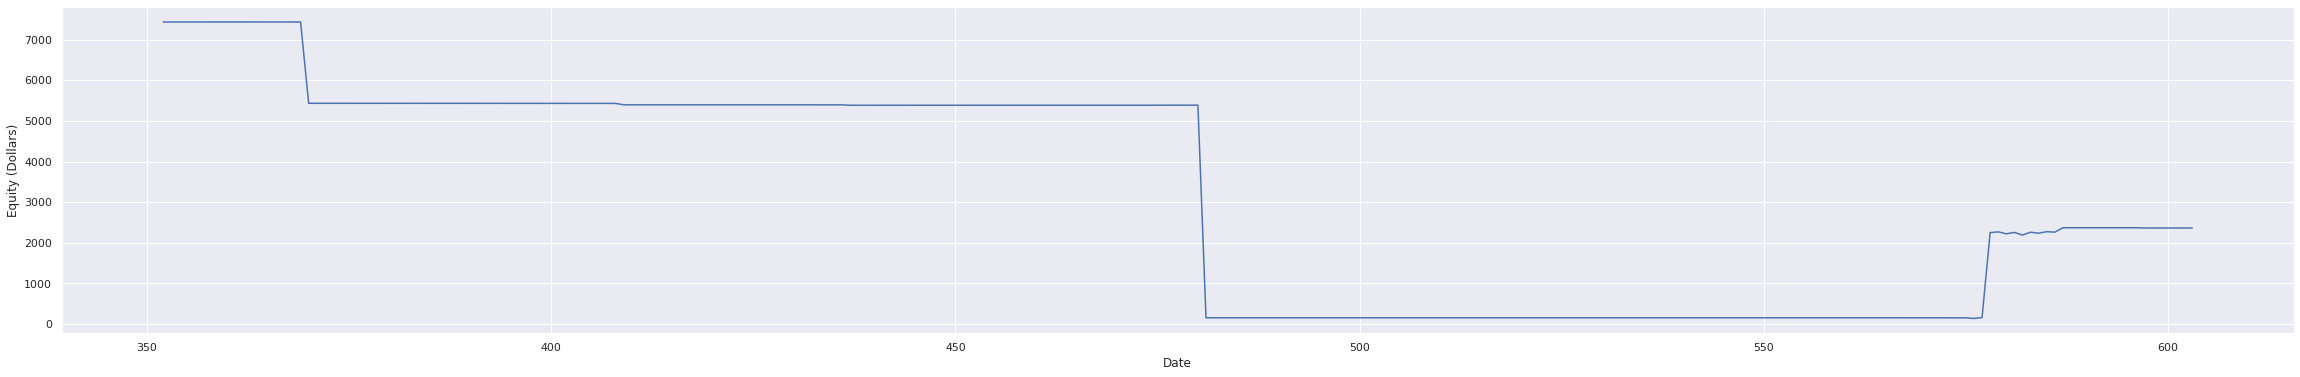

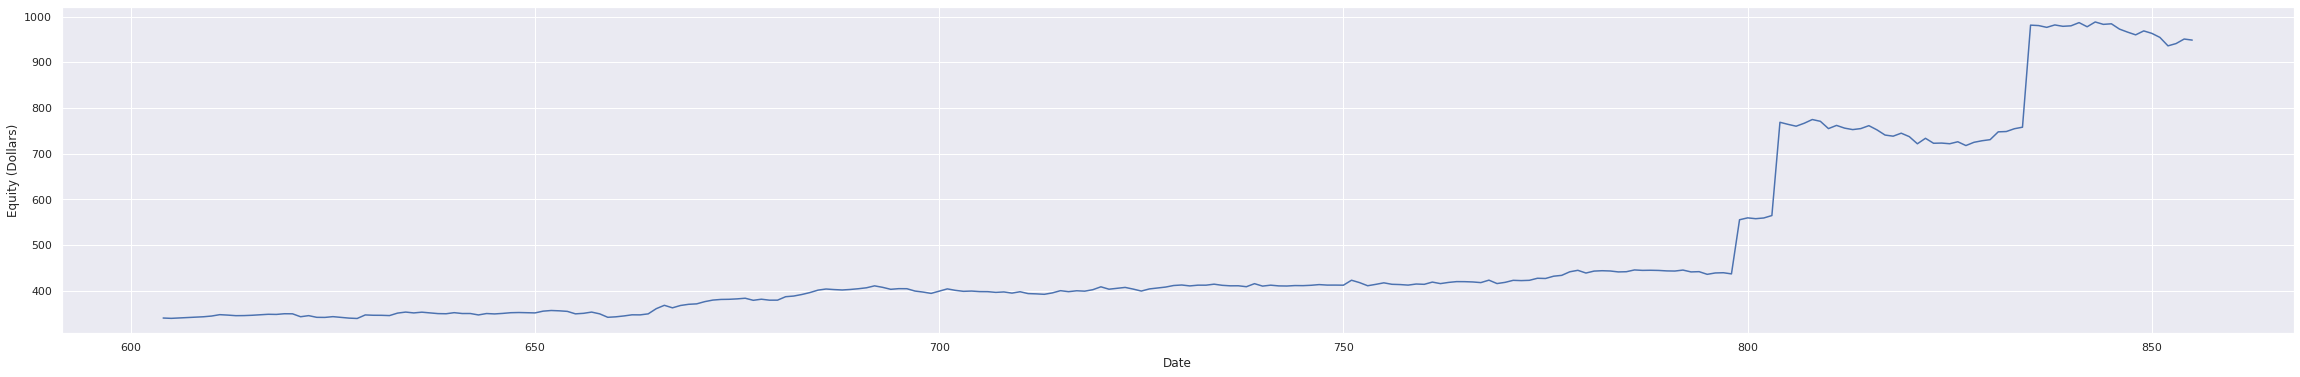

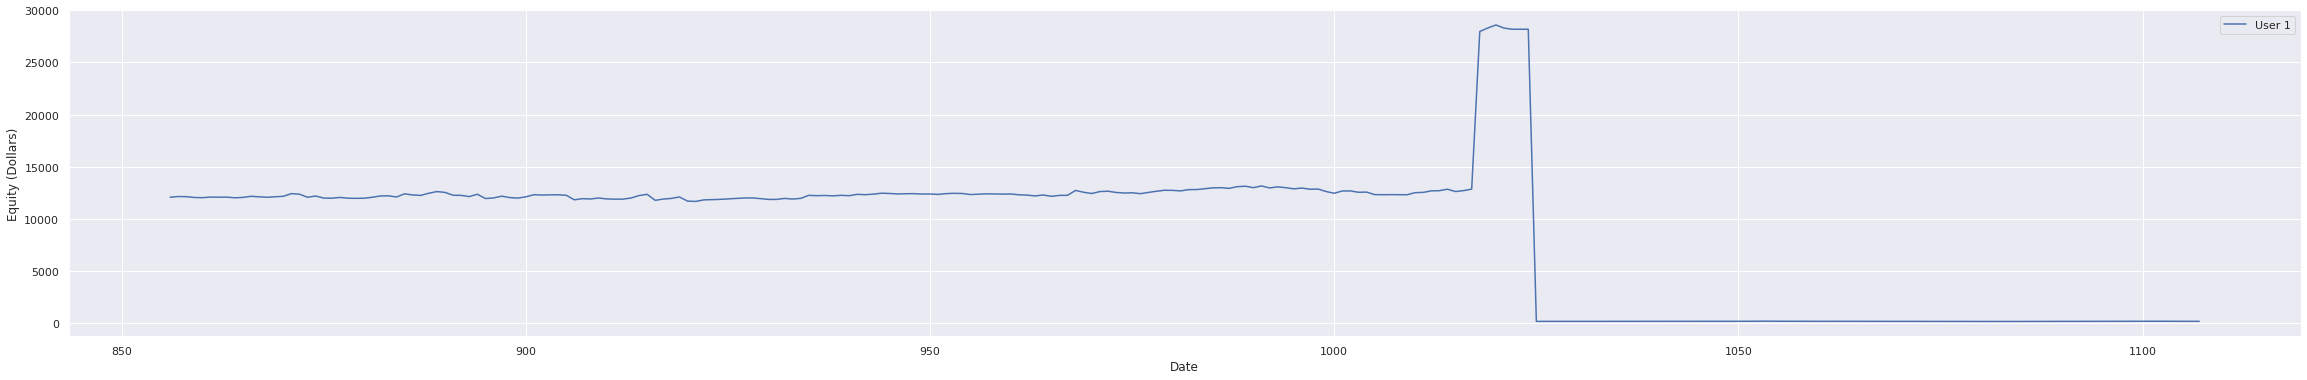

In [252]:
for i in range(5):
    user_eq_df=eq_df[eq_df['user_id']==eq_df[eq_df.columns[2]].unique()[i]]
    
    plt.figure(figsize=(40,6))
    
    ts=user_eq_df["close_equity"]
    time=user_eq_df["timestamp"]
    
    plt.xlabel('Date')
    plt.ylabel('Equity (Dollars)')
    plt.plot(ts, '-', label='User 1');
plt.legend()
plt.show()

In [480]:
feat_df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91


In [481]:
churned_df=pd.DataFrame(churned_user_ids, columns=['user_id'])
churned_df['churn']=1
churned_df.head()

,user_id,churn
0,270cda53a026bcf6c2b98492b23c1b99,1
1,319c069e77187c7e7e7c027eb00fd941,1
2,ec84f134c5b27c4f5702803e98eb3f40,1
3,6dbedf7f2972b4f6ea60a15d48cb292c,1
4,91837d41270b81b267fc205c3e03ee9b,1


In [482]:
model_df=feat_df.merge(churned_df, how='left', on='user_id').fillna(0)
model_df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0.0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0.0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0.0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0.0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0.0


In [483]:
model_df['churn']=model_df['churn'].astype(int)
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5584 entries, 0 to 5583
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   risk_tolerance                5584 non-null   object 
 1   investment_experience         5584 non-null   object 
 2   liquidity_needs               5584 non-null   object 
 3   platform                      5584 non-null   object 
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object 
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object 
 8   user_id                       5584 non-null   object 
 9   churn                         5584 non-null   int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 479.9+ KB


In [484]:
model_df.nunique()

risk_tolerance                     3
investment_experience              4
liquidity_needs                    3
platform                           3
time_spent                      4502
instrument_type_first_traded      11
first_deposit_amount             317
time_horizon                       3
user_id                         5584
churn                              2
dtype: int64

In [485]:
model_df.columns

Index(['risk_tolerance', 'investment_experience', 'liquidity_needs',
       'platform', 'time_spent', 'instrument_type_first_traded',
       'first_deposit_amount', 'time_horizon', 'user_id', 'churn'],
      dtype='object')

In [486]:
# Scaling of features

from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

# We will use Robust scaler because it's ideal if there are outliers

model_df['time_spent'] = rob_scaler.fit_transform(model_df['time_spent'].values.reshape(-1,1))
model_df['first_deposit_amount'] = rob_scaler.fit_transform(model_df['first_deposit_amount'].values.reshape(-1,1))

model_df.describe()

,time_spent,first_deposit_amount,churn
count,5584.000000,5584.000000,5584.000000
mean,0.679098,1.185704,0.051397
std,5.006649,4.707385,0.220826
min,-0.435020,-0.222222,0.000000
25%,-0.343045,-0.111111,0.000000
50%,0.000000,0.000000,0.000000
75%,0.656955,0.888889,0.000000
max,283.289013,110.888889,1.000000


In [487]:
cat_df = model_df.select_dtypes(include=['object']).copy()

# Encoding the columns

enc_make = OrdinalEncoder()

cat_df_transformed = enc_make.fit_transform(cat_df)

for i,j in enumerate(cat_df.columns):
  cat_df[j] = cat_df_transformed.transpose()[i]

model_df_1 = model_df.copy()
# Adding converted labels to df
for i in model_df_1.columns:
  if i in cat_df.columns:
    model_df_1[i] = cat_df[i]

model_df_1.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn
0,0.0,2.0,2.0,0.0,0.634536,8.0,-0.133333,1.0,2970.0,0
1,2.0,2.0,2.0,0.0,0.100042,8.0,0.222222,2.0,1512.0,0
2,2.0,2.0,2.0,2.0,-0.111908,8.0,-0.166667,0.0,4326.0,0
3,2.0,2.0,2.0,0.0,-0.401715,8.0,0.000000,2.0,3854.0,0
4,0.0,2.0,2.0,0.0,-0.170701,8.0,-0.177778,0.0,1615.0,0


# **Without removing the imbalance of the classes**

Churn events fraction in the data : 5.139684813753582
Non-churn events fraction in the data : 94.86031518624641


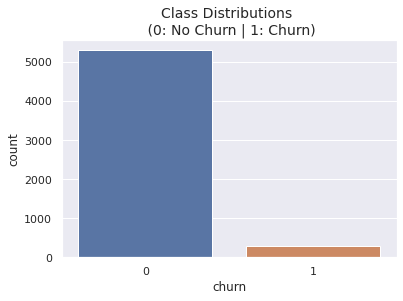

In [488]:
# Class balance

print('Churn events fraction in the data :',len(model_df[model_df['churn']==1])/len(model_df)*100)
print('Non-churn events fraction in the data :',len(model_df[model_df['churn']==0])/len(model_df)*100)

sns.set_theme(style="darkgrid")
g=sns.countplot(data=model_df, x='churn')

plt.title('Class Distributions \n (0: No Churn | 1: Churn)', fontsize=14)
plt.show()

# Class imbalance needs to be taken care before applying model

### K-Fold Stratified cross-validation on imbalanced data

In [502]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, LogisticRegression

df=model_df_1#.drop([])

FEATURES=list(df.columns[0:9]) # Change the columns according to dataset
TARGET='churn'
f1score=[]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(df[FEATURES], df[TARGET])):
    X_train, X_valid = df.iloc[train_idx], df.iloc[valid_idx]
    y_train = X_train[TARGET]
    y_valid = X_valid[TARGET]
    X_train = X_train.drop(TARGET, axis=1)
    X_valid = X_valid.drop(TARGET, axis=1)
    
    cbr = tree.DecisionTreeClassifier()

    cbr =  cbr.fit(X_train, y_train)
    y_pred = cbr.predict(X_valid)
    f1score.append(f1_score(y_valid, y_pred))
    print(f'Fold {fold}: F1: ', f1_score(y_valid, y_pred))

Fold 0: F1:  0.030534351145038167
Fold 1: F1:  0.07575757575757576
Fold 2: F1:  0.10526315789473685
Fold 3: F1:  0.043795620437956206
Fold 4: F1:  0.10526315789473684




> Poor performance from imbalanced data. No surprises here.





In [505]:
# Splitting the data

X = model_df_1.drop(columns = ['churn', 'user_id'])
y = model_df_1['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)

(4467, 8)
(4467,)


### Random Forest with a single validation data

Accuracy (in %): 94.00179051029544
F1 score 0.0
AUC Score =  0.5836119393994157


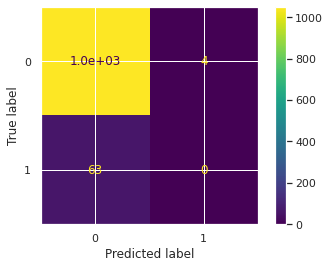

In [506]:
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X_train, y_train)

print("Accuracy (in %):",clf.score(X_test, y_test)*100)

y_pred = clf.predict(X_test)
print('F1 score', f1_score(y_test, y_pred))

plot_confusion_matrix(clf, X_test, y_test)  

print('AUC Score = ', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

plt.show()

> Good accuracy, but poor precision and recall. 

[0.03932548 0.06921133 0.03349972 0.04054636 0.47670251 0.04313542
 0.2453436  0.05223558]


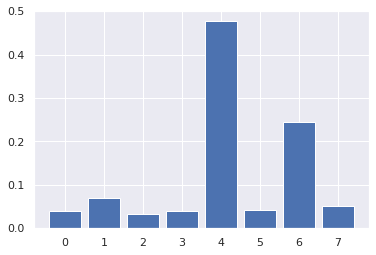

In [507]:
# Let's check the feature importance

importance=clf.feature_importances_
print(importance)
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# Balancing the classes by undersampling

In [508]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Number of fraud classes are fraud_len

churn_df = model_df_1[model_df_1['churn'] == 1]
churn_len=len(churn_df)
non_churn_df = model_df_1[model_df_1['churn'] == 0][:churn_len]

balanced_df = pd.concat([churn_df, non_churn_df])

# Shuffle 
new_df = balanced_df.sample(frac=1, random_state=None)

new_df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn
225,0.0,2.0,2.0,2.0,-0.015103,8.0,0.000000,2.0,1399.0,0
3306,2.0,2.0,2.0,1.0,-0.132727,8.0,-0.111111,2.0,3116.0,1
2310,0.0,2.0,2.0,0.0,8.799391,8.0,6.444444,1.0,2077.0,1
4059,0.0,1.0,2.0,0.0,0.433907,3.0,2.000000,0.0,3902.0,1
4802,2.0,2.0,2.0,2.0,-0.141225,1.0,4.222222,0.0,2157.0,1


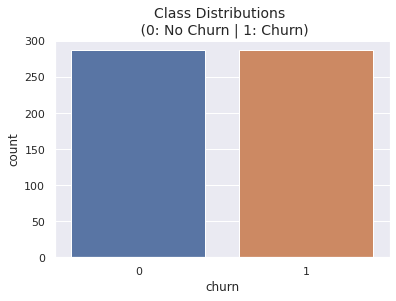

In [509]:
# Classes balanced

sns.set_theme(style="darkgrid")
sns.countplot(data=new_df, x='churn')
plt.title('Class Distributions \n (0: No Churn | 1: Churn)', fontsize=14)
plt.show()

In [510]:
X=new_df.drop(columns = ['churn', 'user_id'], axis=1)
y=new_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(459, 8)
(115, 8)


Accuracy (in %): 49.56521739130435
F1 score 0.532258064516129
AUC Score =  0.4758015728977617


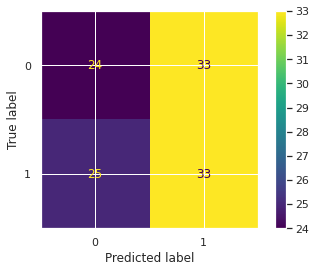

In [514]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

print("Accuracy (in %):",clf.score(X_test, y_test)*100)

y_pred = clf.predict(X_test)
print('F1 score', f1_score(y_test, y_pred))

plot_confusion_matrix(clf, X_test, y_test)  

print('AUC Score = ', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

plt.show()

Accuracy (in %): 53.91304347826087
F1 score 0.5309734513274337
AUC Score =  0.5314579552329098


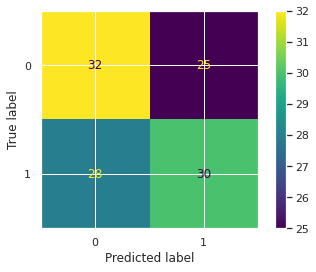

In [512]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=200, random_state=0)

clf.fit(X_train, y_train)
print("Accuracy (in %):",clf.score(X_test, y_test)*100)

y_pred = clf.predict(X_test)
print('F1 score', f1_score(y_test, y_pred))

plot_confusion_matrix(clf, X_test, y_test)  

print('AUC Score = ', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

plt.show()

[0.05968032 0.08542719 0.05050486 0.06558335 0.33431396 0.04874275
 0.28910415 0.06664341]


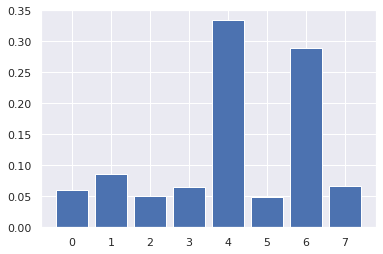

In [516]:
# Let's check the feature importance

importance=clf.feature_importances_
print(importance)
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## **Balancing the classes by undersampling improved the performance. However, the F1 score average is still only 0.53. Not good enough.**

# SMOTE to oversample the minority classes for better prediction

In [517]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from numpy import where

# Imbalanced data reloaded for oversampling

X = model_df_1.drop(columns = ['churn', 'user_id'])
y = model_df_1['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)


(4467, 8)
(8475, 8)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy (in %): 93.72345445965078
F1 score 0.9356555394291243
AUC Score =  0.9826545035193631


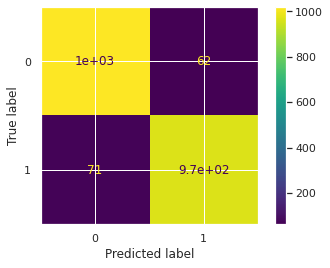

In [518]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

print("Accuracy (in %):",clf.score(X_test, y_test)*100)

y_pred = clf.predict(X_test)
print('F1 score', f1_score(y_test, y_pred))

plot_confusion_matrix(clf, X_test, y_test)  

print('AUC Score = ', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

plt.show()

[0.06438739 0.12089371 0.07073948 0.06699827 0.26225248 0.03254463
 0.30670092 0.07548312]


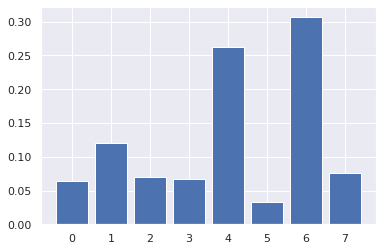

In [519]:
# Let's check the feature importance

importance=clf.feature_importances_
print(importance)
plt.bar([x for x in range(len(importance))], importance)
plt.show()